# **Lab 2 Pruning MobileNetV2**

### Goals

In this assignment, you will practice pruning a classical neural network model to reduce both model size and latency. The goals of this assignment are as follows:

- Understand the basic concept of **pruning**
- Implement and apply **fine-grained pruning**
- Implement and apply **channel pruning**
- Get a basic understanding of performance improvement (such as speedup) from pruning
- Understand the differences and tradeoffs between these pruning approaches

### Contents


There are two main sections in this lab: ***Fine-grained Pruning*** and ***Channel Pruning***.

- For part 1, we will learn about *Fine-grained Pruning*, there are ***5*** questions (Question 1-5).
- For part 2, we will apply *Channel Pruning* to observe speedup on inference

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and mobilenetV2 network which is the same as what we used in the Lab 0 tutorial.

In [1]:
print('Installing torchprofile...')
!pip install torchprofile #1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.1 MB/s eta 0

In [1]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [4]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [5]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [6]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

Load the pretrained model and the CIFAR-10 dataset.

In [7]:
# from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
# model = mobilenet_v2()
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)

model = torch.load("mobilenetv2_0.963.pth", map_location="cpu")
model.cuda()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:
transforms = {
    "train": Compose([
      Resize((224, 224)),
      ToTensor(),
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": Compose([
      Resize((224, 224)),
      ToTensor(),
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )

# You can apply your own batch_size
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=64,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
    drop_last=True
  )

Files already downloaded and verified
Files already downloaded and verified


# Let's First Evaluate the Accuracy and Model Size of Dense Model.

 Neural networks have become ubiquitous in many applications. Here we have loaded a pretrained MobileNetV2 model for classifying images in CIFAR10 dataset.

Let's first evaluate the accuracy and model size of this model.

In [9]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/156 [00:00<?, ?it/s]

dense model has accuracy=96.30%
dense model has size=8.53 MiB


While large neural networks are very powerful, their size consumes considerable storage, memory bandwidth, and computational resources.
As we can see from the results above, a model for the task as simple as classifying $224\times224$ images into 10 classes can be as large as 8.5 MiB.
For embedded mobile applications, these resource demands become prohibitive.

Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.

The goal of pruning is to reduce the model size while maintaining the accuracy.

# Let's see the distribution of weight values

Before we jump into pruning, let's see the distribution of weight values in the dense model.

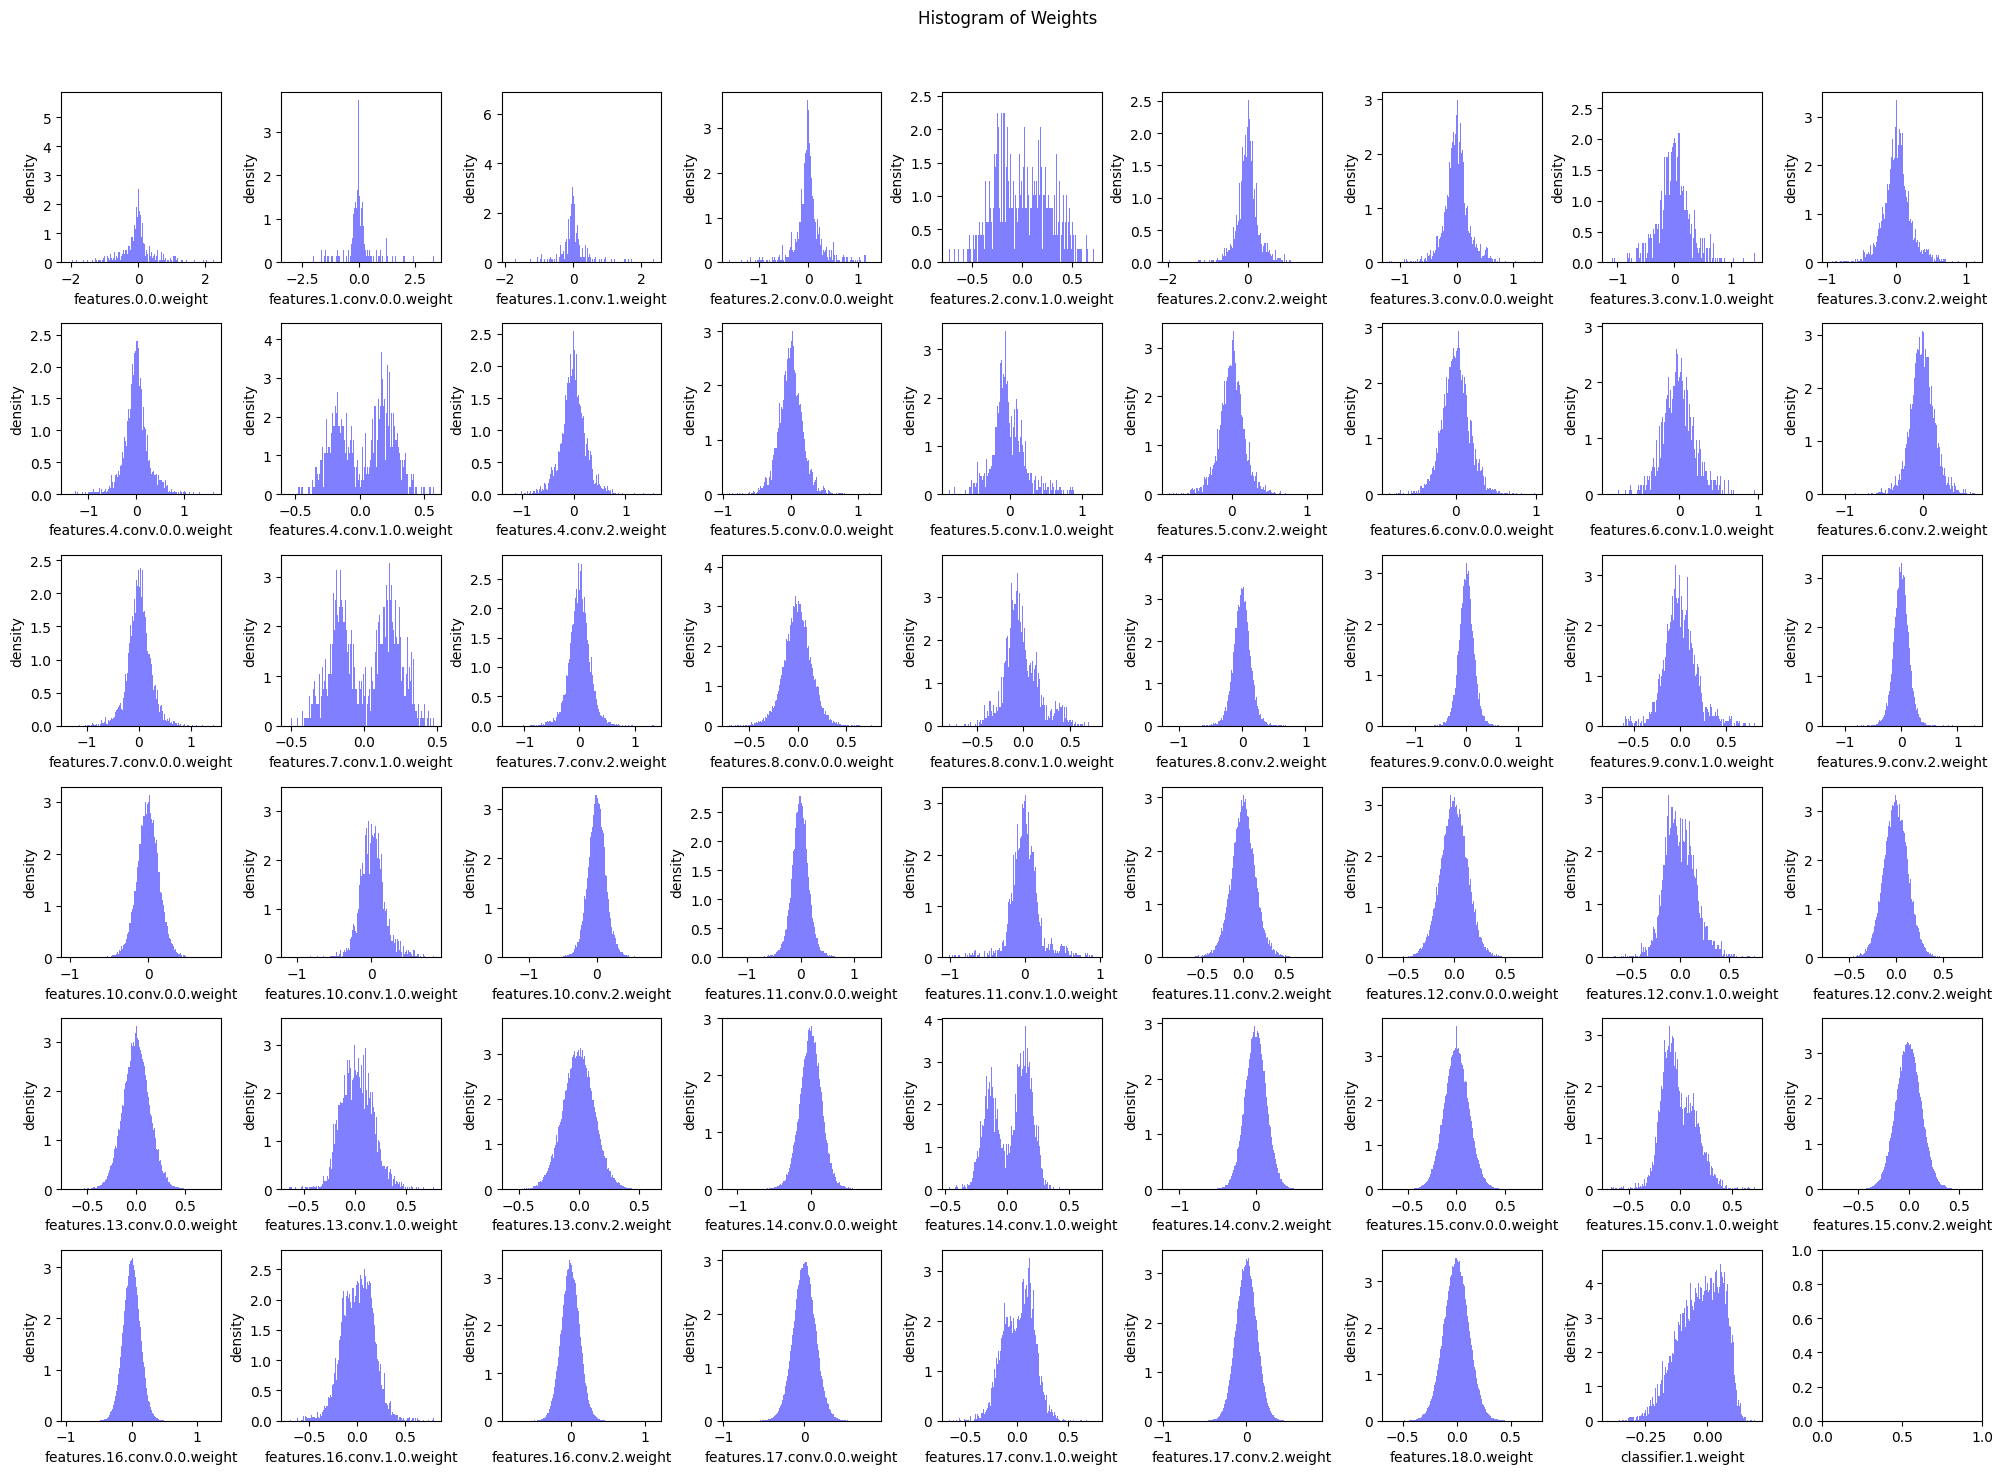

In [10]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(6, 9, figsize=(20, 15))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

## Question 1 (5%)

Please answer the following questions using the information in the above histograms of weights.


### Question 1.1 (2%)

What are the common characteristics of the weight distribution in the different layers?

**Your Answer:** Most of the weight is a unimodel function whose mean is nearly zero, which means that a large portion of weight are zero.

### Question 1.2  (3%)

How does these characteristics help pruning?

**Your Answer:** We can prune the weight which value is nearly zero since it do not contribute much to the prediction. These characteristics show that there are many weights can be pruned, which help pruning.

# Part 1: Fine-grained Pruning (Unstructered Pruning)

In this section, we will implement and perform fine-grained pruning.

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.

## Magnitude-based Pruning

For fine-grained pruning, a widely-used importance is the magnitude of weight value, *i.e.*,

$Importance=|W|$

This is known as **Magnitude-based Pruning** (see [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

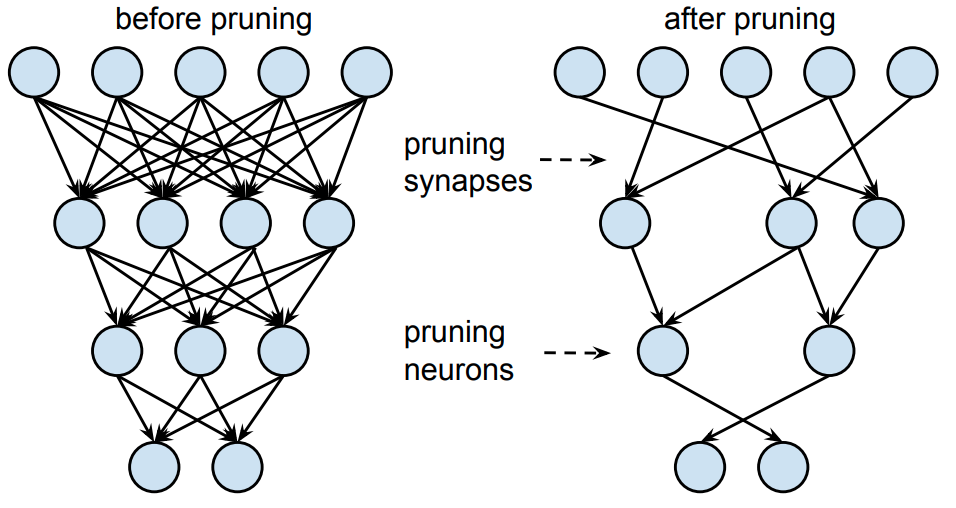

### Question 2 (15 pts)

Please complete the following magnitude-based fine-grained pruning function.

**Hint**:
*   In step 1, we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.
*   In step 2, we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.
*   In step 3, we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.
*   In step 4, we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [11]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """

    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    # in case the tensor is multi-dimension
    flattened_tensor = importance.view(-1)
    threshold, _ = torch.kthvalue(flattened_tensor, num_zeros, dim=-1)
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold).int()
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

Let's verify the functionality of defined fine-grained pruning by applying the function above on a dummy tensor.

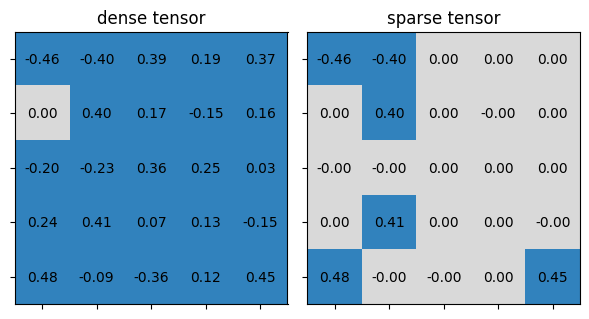

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [12]:
test_fine_grained_prune()

### Question 3 (5 pts)

The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

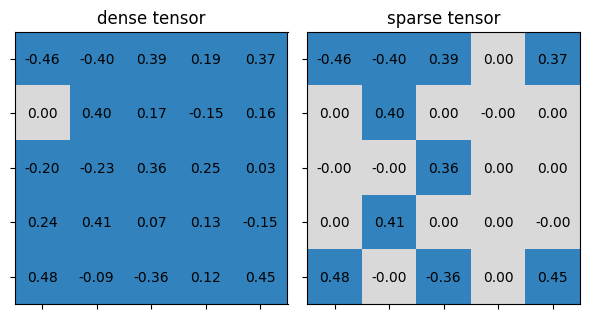

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [13]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = 0.6
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class `FineGrainedPruner`, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [14]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy. (This is Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))


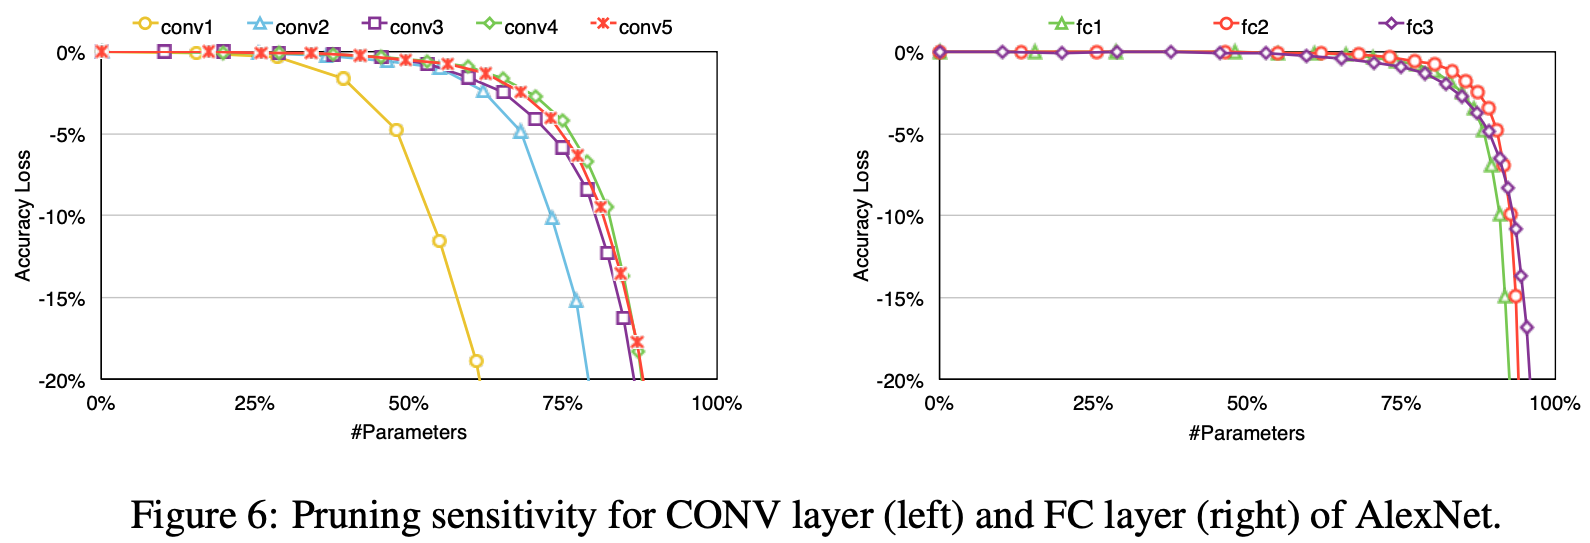

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.

In [15]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]

    for i_layer, (name, param) in enumerate(named_conv_weights):

        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

Please run the following cells to plot the sensitivity curves. You can run through different sparsities and check sensitivity.

In [16]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.0, scan_end=1.0)

scanning 0/53 weight - features.0.0.weight:   0%|          | 0/10 [00:00<?, ?it/s]

    sparsity=0.10: accuracy=96.29%

KeyboardInterrupt: 

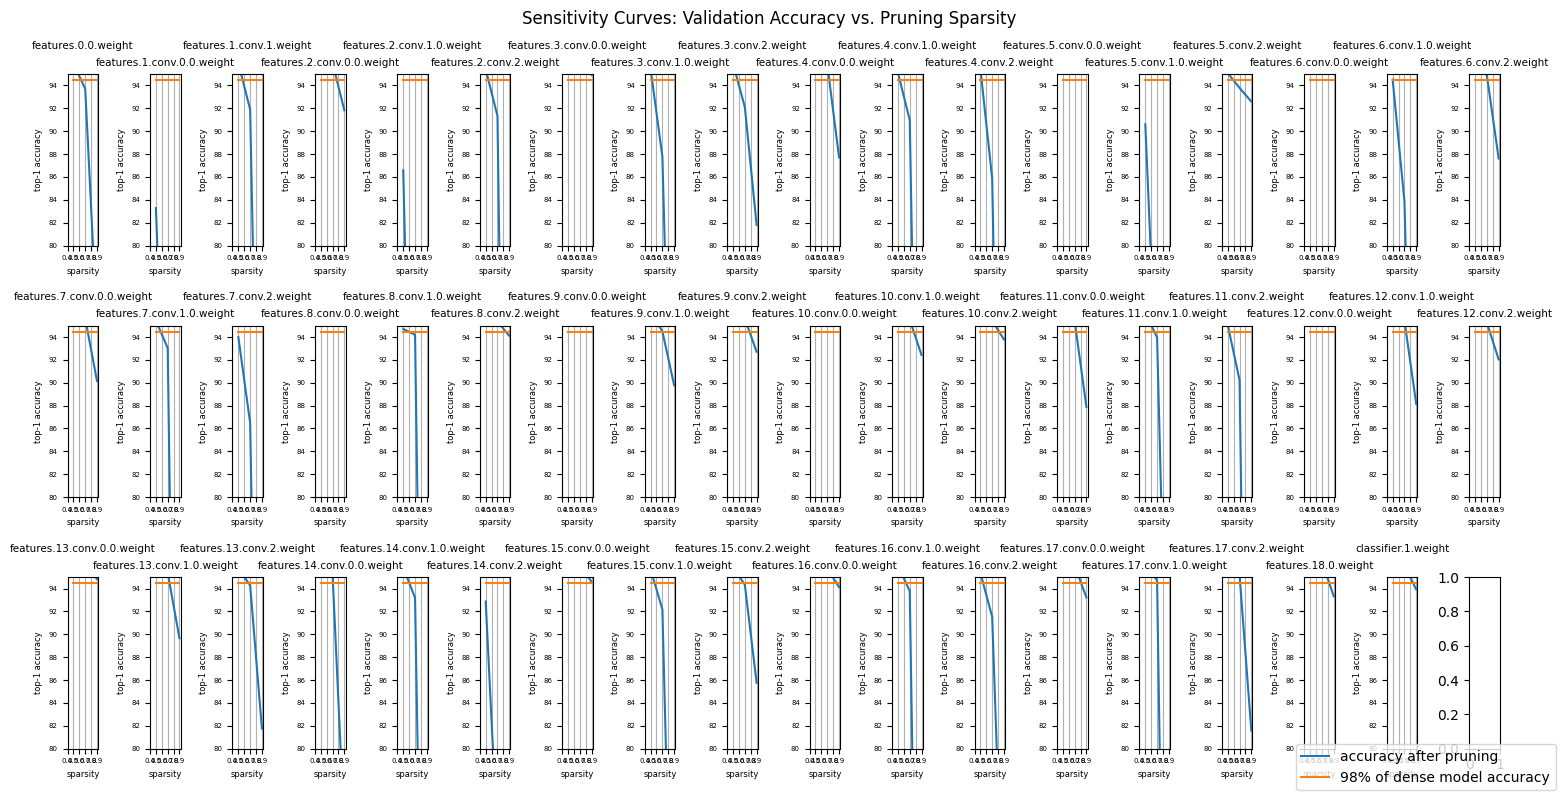

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.tick_params(axis='both', which='major', labelsize=5)

            ax.set_ylim(80, 95)
            if plot_index % 2 == 0:
                ax.set_title(name, fontsize=7.5, y=1.1)
            else:
                ax.set_title(name, fontsize=7.5)
            ax.set_xlabel('sparsity', fontsize=6)
            ax.set_ylabel('top-1 accuracy', fontsize=6)

            ax.grid(axis='x')
            plot_index += 1
    fig.legend([
        'accuracy after pruning',
        f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
    ], loc='lower right')
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity',)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

### Question 4 (15 pts)

Please answer the following questions using the information in the above sensitivity curves.

#### Question 4.1 (5 pts)

What's the relationship between pruning sparsity and model accuracy? (*i.e.*, does accuracy increase or decrease when sparsity becomes higher?)

**Your Answer:** When sparsity become higher, the accuracy decrease.

#### Question 4.2 (5 pts)

Do all the layers have the same sensitivity?

**Your Answer:** No, they do not have the same sensitivity.

#### Question 4.3 (5 pts)

Which layer is the most sensitive to the pruning sparsity?

**Your Answer:** I think that the layer with weight "features.1.conv.0.0.weight" is most sensitive the to the pruning sparsity since when sparsity of this layer is 0.4, the accuracy drop to around 88%, unlike others are aroun 95%. This means that the small change of this weight will contribute to large change in accuracy, so this layer is the most sensitive to the pruning sparsity.

## \#Parameters of each layer
In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

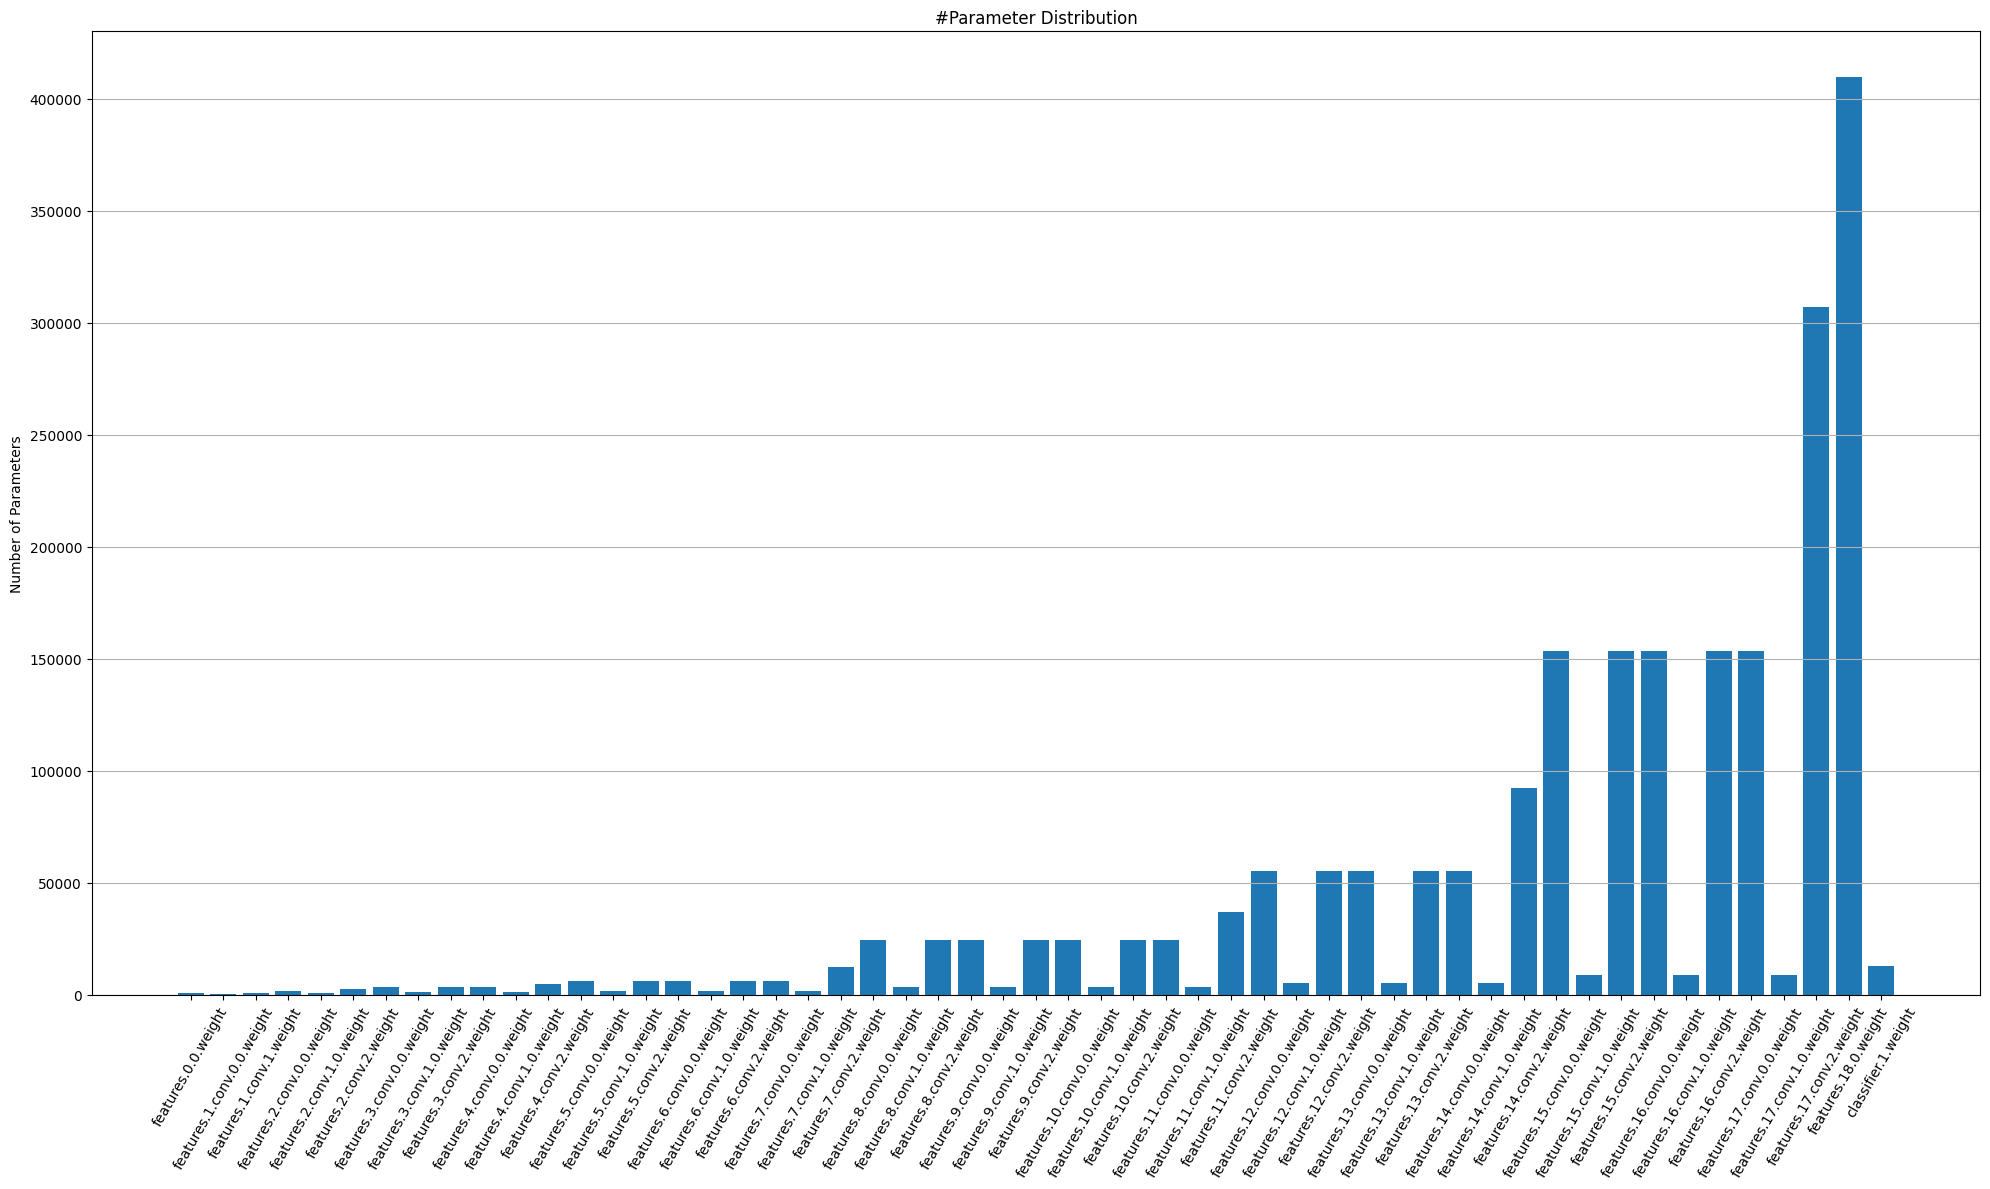

In [100]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(20, 12))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution



### Question 5 (10 pts)

Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.

**Hint**:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [17]:
def recover_model():
  from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
  model = mobilenet_v2()

  NUM_CLASSES=10
  model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
  model = torch.load("mobilenetv2_0.963.pth")
  model.cuda()

  return model

In [119]:
model = recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'features.0.0.weight': 0,
    'features.1.conv.0.0.weight': 0,
    'features.1.conv.1.weight': 0,
    'features.2.conv.0.0.weight': 0,
    'features.2.conv.1.0.weight': 0,
    'features.2.conv.2.weight': 0,
    'features.3.conv.0.0.weight': 0,
    'features.3.conv.1.0.weight': 0,
    'features.3.conv.2.weight': 0,
    'features.4.conv.0.0.weight': 0,
    'features.4.conv.1.0.weight': 0,
    'features.4.conv.2.weight': 0,
    'features.5.conv.0.0.weight': 0,
    'features.5.conv.1.0.weight': 0,
    'features.5.conv.2.weight': 0,
    'features.6.conv.0.0.weight': 0,
    'features.6.conv.1.0.weight': 0,
    'features.6.conv.2.weight': 0,
    'features.7.conv.0.0.weight': 0,
    'features.7.conv.1.0.weight': 0,
    'features.7.conv.2.weight': 0,
    'features.8.conv.0.0.weight': 0,
    'features.8.conv.1.0.weight': 0,
    'features.8.conv.2.weight': 0,
    'features.9.conv.0.0.weight': 0,
    'features.9.conv.1.0.weight': 0,
    'features.9.conv.2.weight': 0.7,
    'features.10.conv.0.0.weight': 0.7,
    'features.10.conv.1.0.weight': 0,
    'features.10.conv.2.weight': 0.7,
    'features.11.conv.0.0.weight': 0.7,
    'features.11.conv.1.0.weight': 0,
    'features.11.conv.2.weight': 0.7,
    'features.12.conv.0.0.weight': 0.7,
    'features.12.conv.1.0.weight': 0,
    'features.12.conv.2.weight': 0.7,
    'features.13.conv.0.0.weight': 0.7,
    'features.13.conv.1.0.weight': 0,
    'features.13.conv.2.weight': 0.7,
    'features.14.conv.0.0.weight': 0.7,
    'features.14.conv.1.0.weight': 0,
    'features.14.conv.2.weight': 0.85,
    'features.15.conv.0.0.weight': 0.85,
    'features.15.conv.1.0.weight': 0,
    'features.15.conv.2.weight': 0.85,
    'features.16.conv.0.0.weight': 0.85,
    'features.16.conv.1.0.weight': 0,
    'features.16.conv.2.weight': 0.85,
    'features.17.conv.0.0.weight': 0.85,
    'features.17.conv.1.0.weight': 0,
    'features.17.conv.2.weight': 0.95,
    'features.18.0.weight': 0.95,
    'classifier.1.weight': 0
##################### YOUR CODE ENDS HERE #######################
}

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

After pruning with sparsity dictionary
  features.0.0.weight: 0.00
  features.1.conv.0.0.weight: 0.00
  features.1.conv.1.weight: 0.00
  features.2.conv.0.0.weight: 0.00
  features.2.conv.1.0.weight: 0.00
  features.2.conv.2.weight: 0.00
  features.3.conv.0.0.weight: 0.00
  features.3.conv.1.0.weight: 0.00
  features.3.conv.2.weight: 0.00
  features.4.conv.0.0.weight: 0.00
  features.4.conv.1.0.weight: 0.00
  features.4.conv.2.weight: 0.00
  features.5.conv.0.0.weight: 0.00
  features.5.conv.1.0.weight: 0.00
  features.5.conv.2.weight: 0.00
  features.6.conv.0.0.weight: 0.00
  features.6.conv.1.0.weight: 0.00
  features.6.conv.2.weight: 0.00
  features.7.conv.0.0.weight: 0.00
  features.7.conv.1.0.weight: 0.00
  features.7.conv.2.weight: 0.00
  features.8.conv.0.0.weight: 0.00
  features.8.conv.1.0.weight: 0.00
  features.8.conv.2.weight: 0.00
  features.9.conv.0.0.weight: 0.00
  features.9.conv.1.0.weight: 0.00
  features.9.conv.2.weight: 0.70
  features.10.conv.0.0.weight: 0.70
  fea

eval:   0%|          | 0/156 [00:00<?, ?it/s]

Sparse model has accuracy=10.02% before fintuning


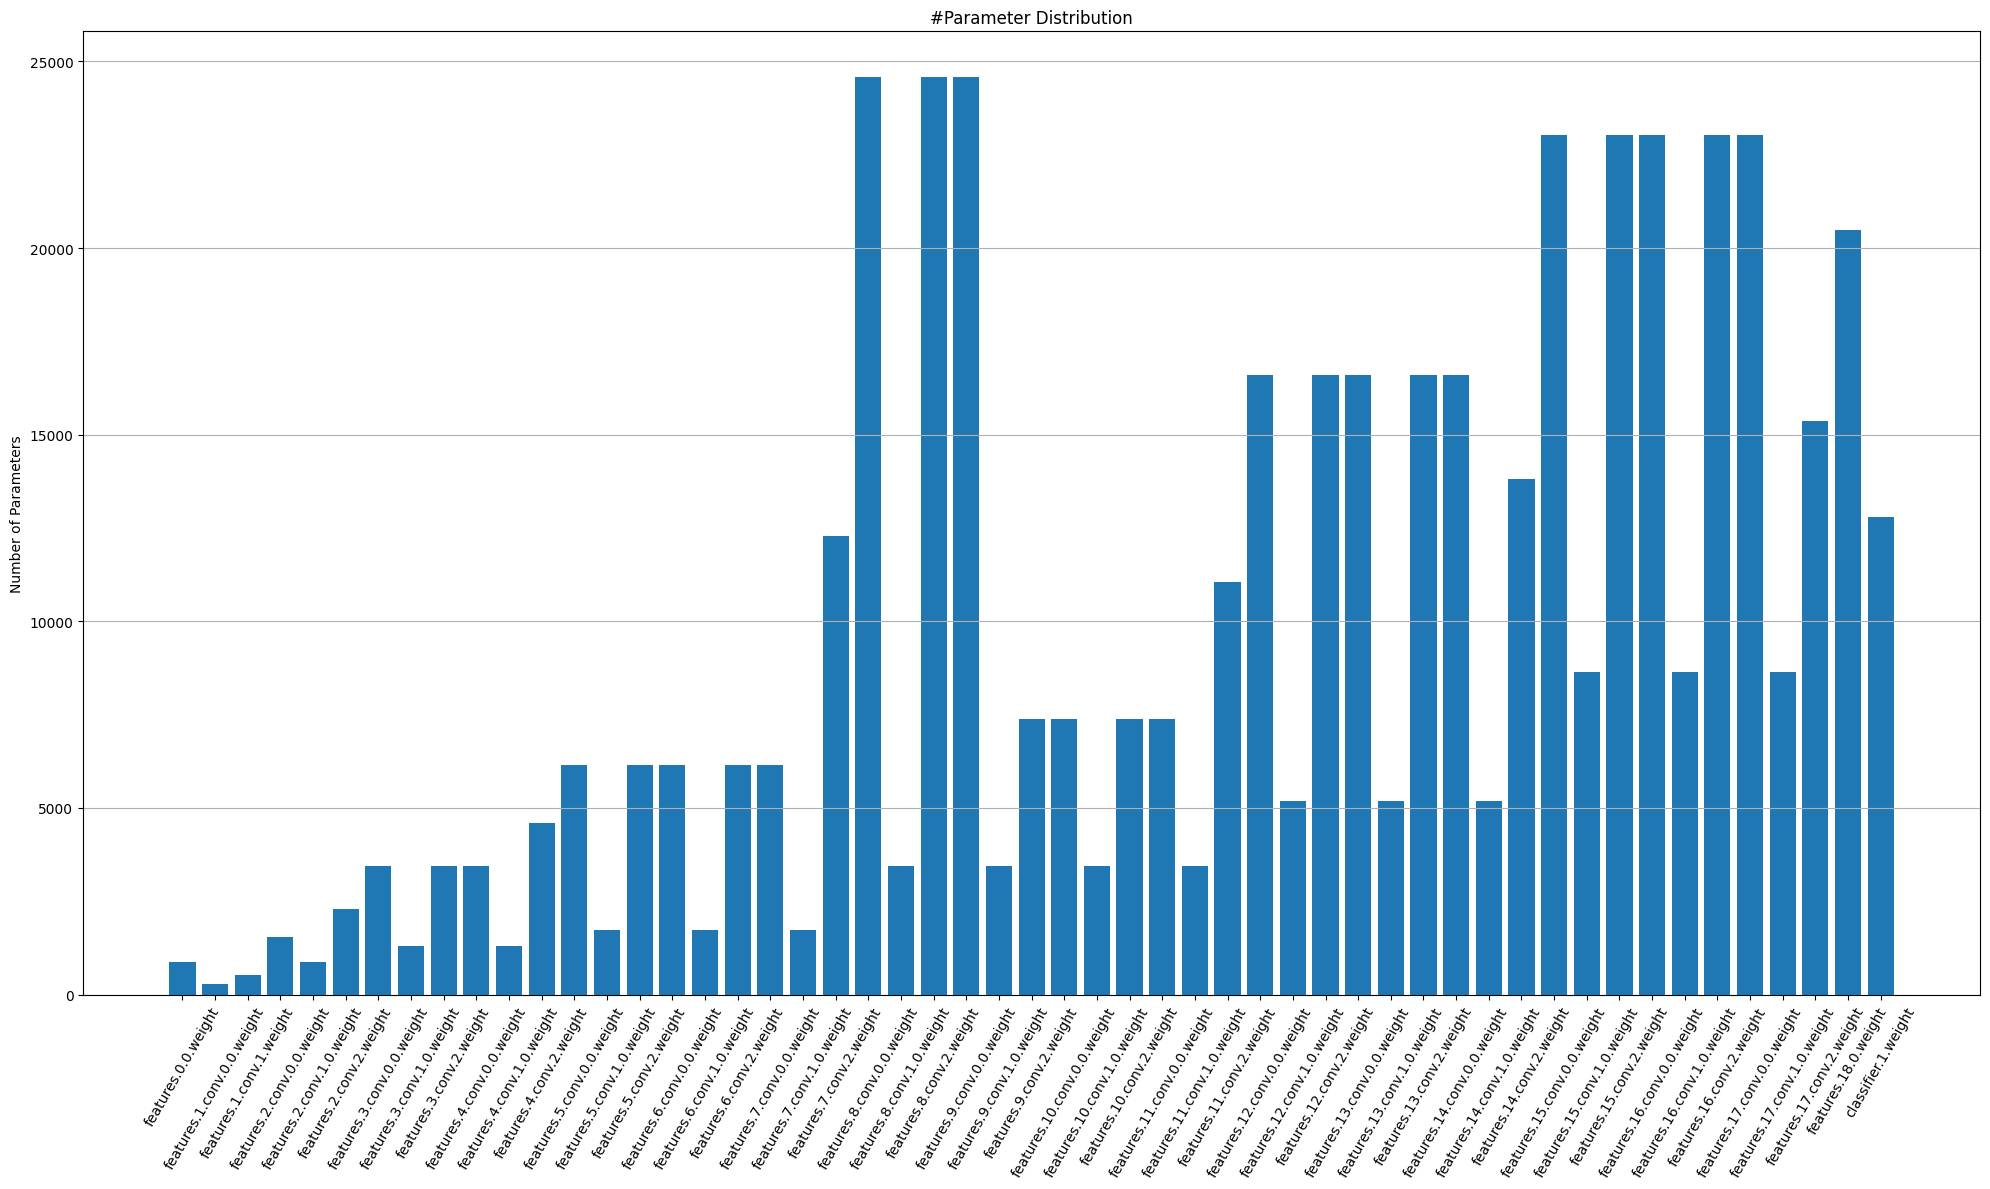

In [120]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

## Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.

In [121]:
# Your can apply your own hyper parameter and do fine-tuning
num_finetune_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 1 Accuracy 88.65% / Best Accuracy: 88.65%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.57% / Best Accuracy: 92.57%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 3 Accuracy 91.63% / Best Accuracy: 92.57%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.31% / Best Accuracy: 92.57%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 5 Accuracy 93.25% / Best Accuracy: 93.25%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 6 Accuracy 93.15% / Best Accuracy: 93.25%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 7 Accuracy 94.12% / Best Accuracy: 94.12%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 8 Accuracy 94.29% / Best Accuracy: 94.29%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 9 Accuracy 94.28% / Best Accuracy: 94.29%


train:   0%|          | 0/781 [00:00<?, ?it/s]

eval:   0%|          | 0/156 [00:00<?, ?it/s]

    Epoch 10 Accuracy 94.18% / Best Accuracy: 94.29%


Run the following cell to see the information of best finetuned sparse model.

In [122]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=2.05 MiB = 23.98% of dense model size


eval:   0%|          | 0/156 [00:00<?, ?it/s]

Sparse model has accuracy=94.29% after fintuning


# Part 2: Channel Pruning Using Torch-Pruning

Channel pruning removes an entire channel at a time, which maintains structured shape, achieving inference speedup on GPUs and edge devices.

In this section, you will perform channel pruning on MobileNetV2 using the library [Torch-Pruning](https://github.com/VainF/Torch-Pruning).

This library captures the dependencies between adjacent model layers, which allows us to perform consistent structural pruning easily.

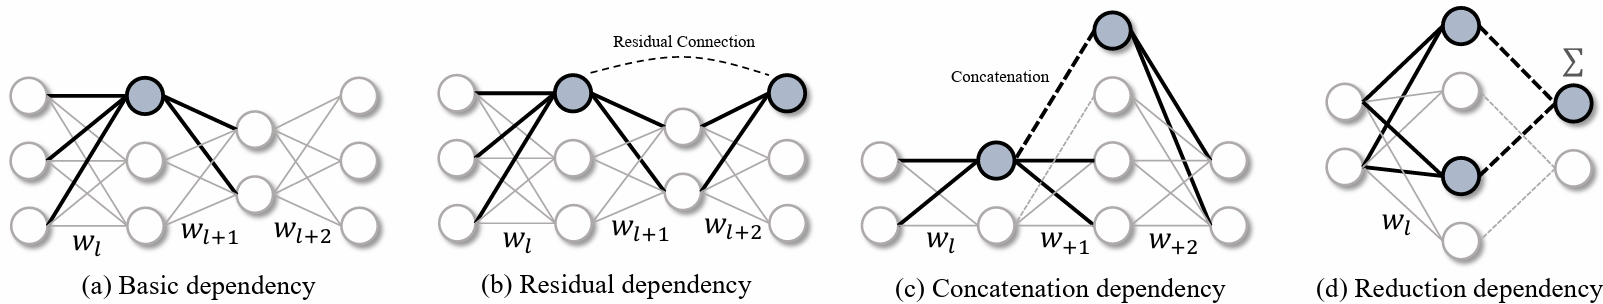

## Prune MobileNetV2 (45%+)

In this part, you will need to visit [Torch-Pruning](https://github.com/VainF/Torch-Pruning), and prune your MobileNetV2 with this library.

For your convinience, we provide a template for running Torch-Pruning using Colab. You don't have to submit this template on e3:
>  [Torch-Pruning Template](https://drive.google.com/file/d/1jh4_stPoNp6c4UnPKXa56WQgApfZl-Np/view?usp=sharing)

In this lab, you will need to submit both ***mobilenet.pth*** and ***mobilenet.pte*** to e3. Refer to [Hand In Policy](https://hackmd.io/EwvWZaONRX29aWPEac2o-w?both#Hand-In-Policy) in lab2 hackmd.


* Obtain the number of MFLOPs of your pruned model using the provided code snippet:
  ```python
  import torch
  import torch_pruning as tp
  from torchvision.models import mobilenet_v2

  model = torch.load('./model/mobilenet.pth', map_location="cpu")
  example_inputs = torch.zeros(1, 3, 224, 224).to(args.device)
  ops, size = tp.utils.count_ops_and_params(model, example_inputs=example_inputs)

  MFLOPs = ops/1e6
  print(MFLOPs)
  ```

Your score for **Part 2** depends on your pruned model's accuracy and MFLOP.

<br>

**The grading formula is as follows:**
$$
  Score = (\dfrac{200 - MFLOPs}{200 - 45} - 10\times Clamp(0.92-Accuracy,\ 0,\ 1)) \times 45\%
$$

It is possible to obtain a score higher than 45%.

**Hint: Refer to Torch-Pruning's [Benchmark Section](https://github.com/VainF/Torch-Pruning/tree/master/benchmarks), and start from their main.py will make your life much easier.**

<br>

* Save the pruned model using the following snippet:
```python
import torch
torch.save(pruned_model, "mobilenet.pth")
```
Then convert the model to binary (*.pte*) and run xnn_executor_runner built from the last lab.

<br>

* You can observe the speedup by comparing the two models before/after pruning with `time` in rpi:
```bash
time ./xnn_executor_runner --model_path ./model/mobilenet(org).pte
time ./xnn_executor_runner --model_path ./model/mobilenet(pruned).pte
```

### Score Calulator
Fill in your model's accuracy and MFLOPs below to obtain your score.

*The score shown below is for reference purpose only. Your final score will be evaluated by TAs through the model's weight you submit.*

In [11]:
Accuracy =  0.906
MFLOPs = 61
print((200-MFLOPs)/(200-45))
print(10*min(max(0.92-Accuracy, 0), 1))
score = max(0, (200-MFLOPs)/(200-45) - 10*min(max(0.92-Accuracy, 0), 1)) * 45
print("Your Score: {:0.2f}/45".format(score))

0.896774193548387
0.20000000000000018
Your Score: 31.35/45


### Describe your approach to pruning MobileNetV2 (5%)

Please detail your method for pruning MobileNetV2 to achieve the final model. Include the following:

* The specific pruning technique used.
* Steps taken to prune and then retrain the model.
* The most effective strategy you discovered for achieving the best result.

(Top methodologies, based on achieved score, will be showcased by TAs in DC as a learning resources for the class.)

**Your Answer:**

I basically followed the template to prune the mobilenetv2. Specifically, I used L2 group norm to calculate the importance of the weight. I used the GroupNormPruner to prune the model. I set iterative steps to iteratively prune the model. In each iteration, after the pruner prune the model, I retrain it a few epoch to make sure the model maintain the accuracy. After all iteration, I do some finetune to further improve the accuracy.